In [1]:
#Import dependencies
from nn import NeuralNetwork
from nn import preprocess
from nn import io
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

# Rationale for Sampling Scheme
In my implementation of sample_seqs, I set a total sample size. I then randomly sample, with replacement, from both the positive and negative examples such that the relative abundance of both classes of examples is exactly equal. Note that since the negative examples are all longer than 17 bp, I randomly selected a 17mer within each negative sequence. I decided to sample in this fashion to address the class imbalance and incongruence of sequence length between classes. 

In [4]:
#Process data for training
pos_file = 'data/rap1-lieb-positives.txt'
neg_file = 'data/yeast-upstream-1k-negative.fa'

#Load sequences and labels
pos_seqs = io.read_text_file(pos_file)
pos_labels = [1] * len(pos_seqs)
neg_seqs = io.read_fasta_file(neg_file)
neg_labels = [0] * len(neg_seqs)
seqs = pos_seqs + neg_seqs
labels = pos_labels + neg_labels

#Sample sequences
seed = 1 #set seed for reproducibility
sampled_seqs, sampled_labels = preprocess.sample_seqs(seqs,labels,1)

#Generate training and validation sets
split_percent = .3
X_train, X_val, y_train, y_val = train_test_split(sampled_seqs, sampled_labels, test_size=split_percent, random_state=42)

#Reshape and one hot encode training and validation sets  
X_train = np.array(preprocess.one_hot_encode_seqs(X_train)).T
X_val = np.array(preprocess.one_hot_encode_seqs(X_val)).T
y_train = np.array([y_train])
y_val = np.array([y_val])

X = np.concatenate((X_train, X_val),axis=1)
y = np.concatenate((y_train, y_val),axis=1)

# Rationale for choice of hyperparameters and loss funciton
With regards to the loss function, I decided to use the binary cross entropy loss, as I felt it would be well-suited for a binary classification problem. Similar to my implementation of an autoencoder, my choice of hyperparamters was based on trial and error. After experimenting with multiple learning rates and batch sizes, I found that keeping the learning rate and batch size relatively small and large produced the most favorable results. Making the learning rate too large and the batch size too small led to instability in my minimization. I also tested how model performance changed with increasing epochs. I found that increases up to 5,000 epochs led to significant improvements in performance. Since the selection of a starting point for gradient descent can influence the minimum converged on, I tested two different random seeds. I found that the initial weights corresponding to seed2 provided the most favorable results. 

To fine tune the network architecture, I tried adding more hidden layers. In all architectures I tested, the dimensionality of the current layer was always less than that of the layer before it. I found that adding an extra hidden layer improved both training and validation loss. Additional layers seemed to elict decreases training loss exclusively. With the optimized architecture in hand, I attempted to further improve performance by experimenting with a ReLu activation functions in the hidden layers, rather than sigmoid. No meaningful differences in validation loss were observed. 

In the future, I think it would be worthwhile to experiment with changing multiple parameters simultaneously, as there may be cooperative effects that were missed in my approach to optimizing model performance. Nonetheless, I'm pleased with how unexpectedly well my model performed. 

In [17]:
#Define hyperparameters
nn_arch = [{'input_dim' :  68, 'output_dim' : 34, 'activation' : 'sigmoid'},
           {'input_dim' :  34, 'output_dim' : 17, 'activation' : 'relu'},
           {'input_dim' : 17, 'output_dim' : 1, 'activation' : 'sigmoid'}]
lr = 0.0005
seed1 = 1
seed2 = 2
batch_size = 400
epochs = 5000
loss_function = 'bce'

In [18]:
#Train classifier
classifier = NeuralNetwork(nn_arch, lr, seed2, batch_size, epochs, loss_function)
train_loss, val_loss = classifier.fit(X_train, y_train, X_val, y_val)

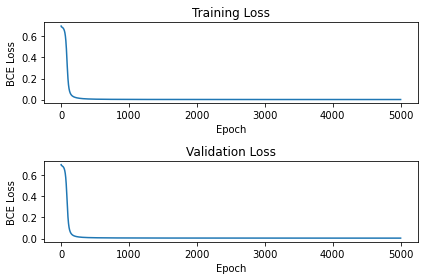

In [19]:
#Plot losses
epochs = np.linspace(1, len(train_loss), len(train_loss))
fig,axs = plt.subplots(2)
axs[0].plot(epochs, train_loss)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('BCE Loss')

axs[1].plot(epochs, val_loss)
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('BCE Loss')
fig.tight_layout()
plt.show()

In [21]:
#Generate predictions for all sequences in X_val
prediction = classifier.predict(X_val)

#Compute accuracy of trained neural network
accuracy = (y_val.shape[1] - np.count_nonzero(y_val - np.round(prediction))) / y_val.shape[1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

print(f'Accuracy of Validation Set: {accuracy}')
print(f'Final Training Loss: {final_train_loss}')
print(f'Final Validation Loss: {final_val_loss}')

Accuracy of Validation Set: 0.998
Final Training Loss: 0.00012243119525033624
Final Validation Loss: 0.004132846881252932
